In [1]:
from scipy.io import arff
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
import matplotlib.pyplot as plt
import seaborn as sns

# Part A : Preprocessing and Initial setup

1. Data Loading

In [2]:
data, meta = arff.loadarff('/content/yeast.arff')
yeast_df=pd.DataFrame(data)

In [3]:
class_columns=[f'Class{i}' for i in range(1, 15)]

In [4]:
X=yeast_df.drop(columns=class_columns)
Y=yeast_df[class_columns]

2. Dimensionality Check

In [5]:
print(f"No. of data points = {X.shape[0]}")
print(f"No. of features in feature matrix = {X.shape[1]}")
print(f"No. of labels = {Y.shape[1]}")

No. of data points = 2417
No. of features in feature matrix = 103
No. of labels = 14


In [6]:
Y = Y.replace({b'0': 0, b'1': 1})
Y

/tmp/ipython-input-322147768.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y = Y.replace({b'0': 0, b'1': 1})


,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2413,1,1,0,0,0,0,0,0,0,0,0,1,1,0
2414,0,0,0,0,0,1,1,1,0,0,0,1,1,0
2415,0,0,0,0,0,0,0,0,0,0,0,1,1,0


Replaces b'0' with 0 and b'1' with 1 for further processing

In [7]:
single_label_rows=Y[Y.sum(axis=1)==1]
single_label_classes=single_label_rows.idxmax(axis=1)
most_common_slc=single_label_classes.value_counts().nlargest(2).index.tolist()
print(f"Most frequent single label class/(es) = {most_common_slc}")

multi_label_rows=Y[Y.sum(axis=1)>1]
combo_counts=multi_label_rows.value_counts()
most_common_mlc=combo_counts.index[0]
print(f"Most commmon multi label combination = {most_common_mlc}")

def label_category(row):
  if tuple(row)==most_common_mlc:
    return "Most_Freq_MLC"
  active_labels=[Y.columns[i] for i, val in enumerate(row) if val==1]
  if len(active_labels)==1 and active_labels[0] in most_common_slc:
    return active_labels[0]
  return "Other"

Y["viz_label"] = Y.apply(label_category, axis=1)

Most frequent single label class/(es) = ['Class1']
Most commmon multi label combination = (np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0))


There was only one single-label class observed **Class1**, the most frequent multi-label combination has entry 1 in **Class3**, **Class4**, **Class12**, **Class13** and 0 in all other classes. The *Other* category is assigned to the rest.

In [8]:
Y

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14,viz_label
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,Other
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,Other
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0,Other
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0,Other
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,0,1,1,0,0,0,0,0,0,0,0,0,0,0,Other
2413,1,1,0,0,0,0,0,0,0,0,0,1,1,0,Other
2414,0,0,0,0,0,1,1,1,0,0,0,1,1,0,Other
2415,0,0,0,0,0,0,0,0,0,0,0,1,1,0,Other


Scaling data is crucial before applying distance-based dimensionality reduction techniques because it prevents features with larger numerical ranges from dominating the distance calculations, which will skew the results and lead to misinterpretations of feature importance and variance. By transforming all features to a similar scale, scaling ensures that each feature contributes equally to the resulting lower-dimensional representation, leading to more accurate and meaningful projections.

In [9]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

# Part B : t-SNE and Veracity Inspection

1. t-SNE Implementation

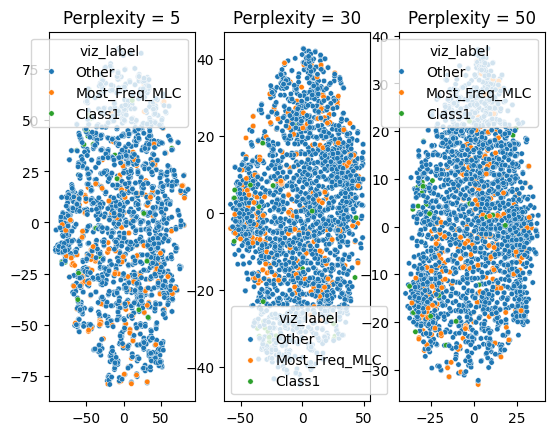

In [10]:
perplexity_values=[5, 30, 50]
tsne_results={}
for p in perplexity_values:
  tsne=TSNE(n_components=2, perplexity=p, random_state=42)
  tsne_results[p]=tsne.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 3)
for ax, p in zip(axes, perplexity_values):
    sns.scatterplot(x=tsne_results[p][:, 0], y=tsne_results[p][:, 1], hue=Y["viz_label"], s=15, ax=ax, legend=True)
    ax.set_title(f"Perplexity = {p}")
plt.show()

Perplexity indicates the the effective number of neighbors each data point considers in its local neighborhood, which controls the balance between emphasizing local and global structures in the data. A low perplexity value focuses more on the local structure. Hence, the plot with perplexity = 5 indicates small, fragmented clusters. With an increase in perplexity values, the nature of the model to preserve gloabl relationships increases and hence, the clusters start losing separation and are packed closer in the lower dimensional space. The perplexity value = 30 is suitable as it captures both the local similarities among closely related points and the global separation between distinct groups.

2. Visualization

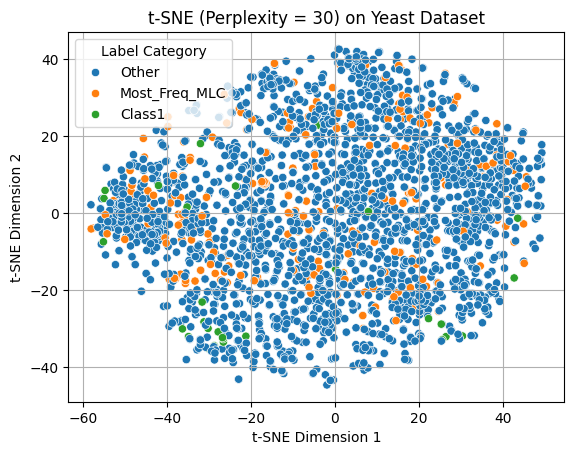

In [11]:
tsne_final=TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords=tsne_final.fit_transform(X_scaled)
plt.figure()
sns.scatterplot(x=tsne_coords[:, 0], y=tsne_coords[:, 1], hue=Y['viz_label'])
plt.title("t-SNE (Perplexity = 30) on Yeast Dataset")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Label Category")
plt.grid(True)
plt.show()

3. Veracity Inspection



*   **Noisy/Ambiguous Labels** : Some orange points are deeply embedded in blue clusters in the regions (t-SNE-1, t-SNE-2) = (35, 15), (0, 25), (-45, 0), indicating genes whose functions span multiple categories or are misclassified.


*   **Outliers** : There are some isolated points or tiny clusters, far away from the dense bulk. For example - Regions where (t-SNE-1, t-SNE-2) = (5, -40), (-30, 30). These indicate highly unusual gene expression profiles, which may represent rare functional classes of genes, unusual expression patterns or noise due to experimental error.

*    **Hard-to-learn samples** : Areas where functional category colors (mostly orange and blue) are thoroughly mixed are - (t-SNE-1, t-SNE-2) = (-30, -15), (20, 25), (-40, 0). In these regions, the functional categories overlap in feature space. A simple classifier (e.g., logistic regression, linear SVM) would likely struggle here because the decision boundary is non-linear, points from different classes share very similar local neighborhoods and are not linearly separable.



# Part C : Isomap and Manifold Learning

1. Isomap Implementation

**Fundamental difference between isomap and t-SNE** :

Isomap preserves the global structure of data by focusing on geodesic distances, while t-SNE preserves the local structure by modeling pairwise similarities with probability distributions. Isomap computes the shortest path between every pair of points in the dataset along the edges of the neighborhood graph, thus preserving the global relationship between all points. t-SNE, on the other hand, calculates the similarity between pairs of data points in the original space and represents these similarities as probabilities. It then creates a low-dimensional map and iteratively adjusts the points to minimize the KL-Divergence between the probability distributions in both spaces. Hence, t-SNE is highly sensitive to local structure. The resulting map is optimized to ensure that similar points (neighbors) stay close together.


In [12]:
isomap=Isomap(n_components=2)
X_iso=isomap.fit_transform(X_scaled)

2. Visualization

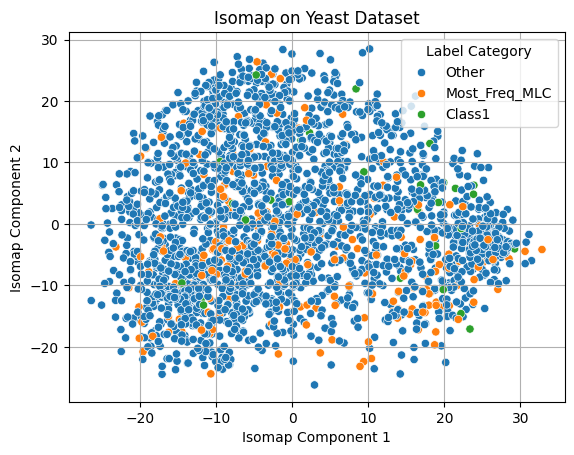

In [13]:
plt.figure()
sns.scatterplot(x=X_iso[:, 0], y=X_iso[:, 1], hue=Y['viz_label'])
plt.title("Isomap on Yeast Dataset")
plt.xlabel("Isomap Component 1")
plt.ylabel("Isomap Component 2")
plt.legend(title="Label Category")
plt.grid(True)
plt.show()

3. Comparison and Curvature

Upon examining the t-SNE and isomap plots, it can be concluded that the **Isomap** is better at revealing the **global structure** in the data while t-SNE is able to better focus on local relationships. t-SNE is better at clustering the data and providing high-density local clusters, but the relative distances between clusters are not meaingful

A data manifold is the lower dimensional subspace embedded within the higher dimensional space where the gene expression data actually lies. The isomap plot is moderately curved with significant overlaps in the *Other* and *Most_Freq_MLC* (most frequeny multi-label classification) classes. A more complex or highly curved manifold can make classification much harder as the classes overlap along complex, non-linear boundaries, increasing the difficulty of linear models like linear SVM or logistic regression to separate such twisted structures effectively.